<a href="https://colab.research.google.com/github/jhermosillo/diplomado_CDD2019/blob/master/04%20Clasificacion_Agrupamiento/1%20Modelos%20Lineales/Notebooks/Perceptron_Kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:50px;" align="left"> <img align="left" width="350" src="../img/modelos_lineales_1.jpg"/> <br>Algoritmo Perceptrón y<br>Perceptron con Kernel</h1>

___

<style>
table, td, th {  
  border: 1px solid #ddd;
  text-align: left;
}
|  <img src="../img/data_science.jpg" width="300"/> |   <font color='midnightblue'>Diplomado en <br> Ciencia de Datos <br> con Python</font>|
|:-:|:-|


&#128214; <u>Referencias bibliográficas</u>:
* Flach, Peter (2012). Machine Learning: The Art and Science of Algorithms that Make Sense of Data. Cambridge University Press.
* Bishop, Christopher M. (2006). Pattern recognition and machine learning. New York. Springer.

___

In [1]:
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import genera_datos as gd

## Funciones utilitarias de graficación

In [2]:
def grafica(x_train,y_train,x_test,y_test):
    """
    Grafica los datos de entrenamiento y prueba
    Entrada: Datos
    Salida: scatter plot con datos diferenciados
    """

    """Areas de Graficacion y visualizacion de los datos"""
    fig,ax = plt.subplots(figsize=(6,5))
    
    clases = np.unique(y_train).astype(int)

    """Datos negativos de entrenamiento"""
    ax.scatter(x_train[:,0][y_train==clases[0]], x_train[:,1][y_train==clases[0]],
               facecolor='royalblue', 
               marker='$\\ominus$', 
               edgecolor='royalblue',
               s=80,
               label='neg train')
    """Datos positivos de entrenamiento"""
    ax.scatter(x_train[:,0][y_train==clases[1]], x_train[:,1][y_train==clases[1]],
               facecolor='orangered', 
               marker='$\\bigoplus$', 
               edgecolor='orangered',
               s=80,
               label='pos train')

    """Datos de PRUEBA"""
    xmin = np.amin(x_train[:,0])+0.05*np.amin(x_train[:,0]) 
    xmax = np.amax(x_train[:,0])+0.05*np.amax(x_train[:,0]) 
    ymin = np.amin(x_train[:,1])+0.05*np.amin(x_train[:,1]) 
    ymax = np.amax(x_train[:,1])+0.05*np.amax(x_train[:,1]) 
    ax.axis([xmin,xmax,ymin,ymax])

    ax.scatter(x_test[:,0][y_test==clases[0]], x_test[:,1][y_test==clases[0]],
               facecolor='k', 
               marker='o', 
               edgecolor='k',
               s=45,
               label='neg test')
    ax.scatter(x_test[:,0][y_test==clases[1]], x_test[:,1][y_test==clases[1]],
               facecolor='r', 
               marker='o', 
               edgecolor='k',
               s=45,
               label='pos test')
    """Parametros de la clave"""
    legend = plt.legend(loc='upper center',
                    bbox_to_anchor=(0.5, 1.075),
                    ncol=4,
                    fancybox=True,
                    shadow=False)

    return fig,ax

def plot_FD(clf,show_SV=False):
    """
    Calcula el contorno de una curva 
    que representa la frontera de decision de un perceptron con kernel no-lineal
    Entrada: apuntador al modelo
    Salida: curva de contorno (grafico)
    """
    #     vectores de soporte
    if show_SV:
        ax.scatter(clf.sv[:,0], clf.sv[:,1], 
                   s=50, 
                   facecolor='none',
                   edgecolor="g",
                   linewidth=3, 
                   zorder=10,
                   label='SV_KERNEL')
    if clf.__class__.__name__=='SVC':
        c='green'
        clave='SVM'
    else:
        c='purple'
        clave=clf.clave
    xmin,xmax=ax.get_xlim()
    ymin,ymax=ax.get_ylim()
    
    X1, X2 = np.meshgrid(np.linspace(xmin,xmax,100), np.linspace(ymin,ymax,100))
    X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
    Z = clf.decision_function(X)
    Z = Z.reshape(X1.shape)
    CS=ax.contour(X1, X2, Z, 0,
                  colors=c, 
                  linestyles='dashed',
                  linewidths=3,
                  origin='lower')
    ax.contourf(X1, X2, Z,alpha=0.2,levels=0,cmap=cm.jet)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    CS.collections[0].set_label(clave)
    """Parametros de la clave"""
    legend = plt.legend(loc='upper center',
                        bbox_to_anchor=(0.5, 1.15),
                        ncol=4,
                        fancybox=True,
                        shadow=False)

    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_alpha(1)
    fig.tight_layout()

    return

## Generador de datos sintéticos

In [3]:
def toy_data(tipo='ls',n=2,s=100,prop=80):
    if tipo=='ls':
        L=gd.datos_lin_separables(samples=s)
    else:
        L=gd.datos_solapados(samples=s)
    
    #Listas de datos y clases
    X=[]
    y=[]
    for i in range(len(L)):
        X.append(L[i][:,:-1])
        y.append(L[i][:,-1].astype(int))

    """Separa los datos en entrenamiento y prueba"""
    #80% de datos para entrenar
    x_train,x_test,y_train,y_test=gd.split_train_test(X,y,prop) 

    """Centra los datos"""
    x_train=gd.centra_datos(x_train)
    x_test=gd.centra_datos(x_test)
    
    clases = np.arange(n,dtype='int')
    clases[0]=-1

    return x_train,x_test,y_train,y_test,clases

# Modelo Perceptron:

<img align="center" width="60%" src="../img/algoritmo_perceptron.jpg"/>

In [4]:
class Perceptron(object):
    """
    Clasificador Perceptron
    """

    def __init__(self, epocas=1, eta=1.):
        self.epocas = epocas    #epocas: 1 por defecto
        self.eta=eta  #tasa de aprendizaje: 1 por defecto

    def fit(self, X, y,show_error=False):
        """
        Funcion de aprendizaje
        Entrada: datos de entrenamiento X,y en coordenadas homogeneas
        Calcula: W, los pesos del modelo, y el Error de aprendizaje
        """         
        n_samples, d_features = X.shape                 #matriz de datos
        self.W = np.zeros(d_features, dtype=np.float64) #vector de pesos en cero
        self.W_history=[]
        errors = []

        for e in range(self.epocas):
            total_error = 0
            for i in range(n_samples):
                if self.predict(X[i])*y[i] <= 0:
                    self.W_history.append(self.W)
                    self.W += y[i] * self.eta * X[i]
                    total_error += self.predict(X[i])*y[i]
            errors.append(total_error)
        if show_error:
            xticks=np.arange(self.epocas)
            plt.xticks(xticks,[str(x) for x in xticks])
            plt.plot(errors,label='Perceptron')
            plt.xlabel('Epoca')
            plt.ylabel('Error total')
            plt.legend()

        
    def predict(self, X):
        """
        Funcion que determina el signo de la proyeccion
        Entrada: arreglo numpy de datos X
        Salida:  arreglo numpy con valores +1 o -1 
        """         
        return np.sign(X@self.W).astype(int)
    
    def metricas(self, y_test, y_predicted):
        """
        Funcion de evaluacion del rendimiento
        Entrada: arreglos numpy con datos de prueba y prediccion
        Salida: exactitud, precision y recall          
        """ 
        #r contiene los indices donde la prediccion y los valores reales coinciden
        r = np.where(y_predicted==y_test)
        acc = y_test[r]
        
        y_p = np.where(y_predicted>0)
        pos=np.where(y_test>0)
        
        FP = set(list(y_p[0])).symmetric_difference(set(list(pos[0])))
        TP = set(list(pos[0]))-FP        
        TP_FP = TP.union(FP) 
                
        #exactitud, precision y sensibilidad
        accuracy= len(acc)/len(y_test)*100
        precision = len(list(TP))/len(list(TP_FP))*100
        recall = len(list(TP))/len(pos[0])*100
        
        return accuracy, precision, recall
    
    def f(self,x,c=0):
        """
        dados x y w, regresa y tal que [x,y] esta sobre la linea
        w.x + b = c
        w es el vector ortogonal a la recta
        """
        v=(-self.W[1:][0] * x - self.W[0] + c) / self.W[1:][1]
        return v

    
    def plot_FD(self,ax):
        """
        Calcula los puntos de la linea recta 
        que representa la frontera de decision de un perceptron lineal
        Entrada: datos de las dos clases X1 y X2
        Salida: dos puntos extremos de la frontera de decision
        """
        xmin,xmax=ax.get_xlim()
        ymin,ymax=ax.get_ylim()

        a0 = xmin
        a1 = self.f(a0)

        b0 = xmax 
        b1 = self.f(b0)
        
        x=[a0,b0]
        y=[a1,b1]
        ymin,ymax=plt.ylim()
        ax.axis([x[0],x[1],ymin,ymax])
        ax.plot(x, y, "k", label='Perceptron')
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)
        #leyenda
        legend = plt.legend(loc='upper center',
                    bbox_to_anchor=(0.5, 1.15),
                    ncol=4,
                    fancybox=True,
                    shadow=False)

        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_alpha(1)
        return


## Prueba del Perceptrón

In [5]:
from sklearn import preprocessing

#Datos
x_train,x_test,y_train,y_test,clases=toy_data(tipo='ls',s=50)

#Transformación de los Datos
scaler = preprocessing.StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test =scaler.fit_transform(x_test)


features = preprocessing.PolynomialFeatures(1)
X_train=features.fit_transform(x_train)
X_test=features.fit_transform(x_test)

PERCEPTRON:
Exactitud   100.0%
Precision   100.0%
Recall      100.0%


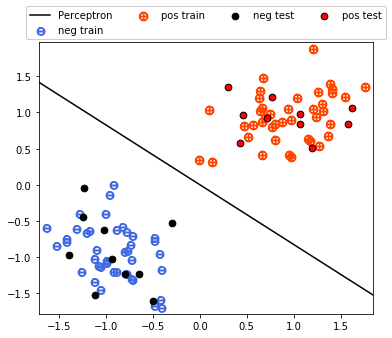

In [6]:
#Declara el modelo
clf = Perceptron()

#entrenamiento
clf.fit(X_train, y_train)

#Prueba y métricas
y_p=clf.predict(X_test)

ex,pr,rec = clf.metricas(y_test,y_p)
print('PERCEPTRON:')
print("Exactitud   " + str(ex) + "%")
print("Precision   " + str(pr) + "%")
print("Recall      " + str(rec) + "%")

#frontera de decision
fig,ax=grafica(x_train,y_train,x_test,y_test)
clf.plot_FD(ax)

## Perceptron con Kernel

&#9998; **Implementa el modelo del Perceptrón DUAL, incluyendo 2 tipos de kernel adicionales al kernel lineal. Se te proporciona una clase Base con un kernel lineal como ejemplo**

In [7]:
class PerceptronKernel():
    """
    Perceptron con Kernel básico
    """
    def __init__(self, kernel='lk',**params):
        self.epocas=1
        if kernel == 'lk':
            self.__kernel=self.__lk
            self.clave = 'K-Lineal'
        elif kernel == 'gk':
            self.__kernel=self.__gk
            self.clave = 'K-Gauss'
        else:
            self.__kernel=self.__pk
            self.clave = 'K-Poli'
        if params:
            for p in params.keys():
                if p=='epocas':
                    self.epocas = params[p]
                    continue
                if p=='gamma':
                    self.gamma=params[p]

    def __lk(self,Xi,Xj):
        return Xi@Xj
    
    def __pk(self,Xi,Xj):
        return (1 + Xi@Xj)**self.gamma

    def __gk(self,Xi, Xj):
        return np.exp(-self.gamma*np.linalg.norm(Xi-Xj)**2)

    @property    
    def kernel(self):
        return self.__kernel
    
    @kernel.setter
    def kernel(self,*args):
        try:
            l=args[0]
            ok=True
            if isinstance(l,str):
                kernel=l
            else:
                kernel=l[0]
                try:
                    parametro=l[1]
                except IndexError:
                    print("ERROR: Debes pasar también un parámetro-> gamma > 0")
                    ok=False
        except IndexError:
            print("ERROR: Debes pasar al menos un argumento con la etiqueta del kernel: {lk,gk,pk}")
            ok=False
        if ok:
            if kernel == 'lk':
                self.__kernel=self.__lk
                self.clave = 'K-Lineal'          #para la leyenda de la imagen
            elif kernel == 'gk':
                self.gamma = parametro       #gamma del kernel gaussiano
                self.__kernel=self.__gk
                self.clave = 'K-Gauss'
            else:
                self.gamma = parametro       #gamma del kernel gaussiano
                self.__kernel=self.__pk
                self.clave = 'K-Poli' 
        return

    def fit(self, X, y):
        """
        Funcion de aprendizaje
        In: X, matriz de instancias de aprendizaje
            y, matriz de clases
        Out: alpha vector de pesos de instancias de aprendizaje
        """         
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples, dtype=np.float64)
        
        clases = np.unique(y).astype(int)
        if clases[0]==0:
            y_temp=y[:]
            y_temp[y==0]=-1
            self.__y=y_temp[:]
            y_temp=[]
        else:
            self.__y=y[:]

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        # Entrenamiento
        for epoca in range(self.epocas):
            for i in range(n_samples):
                if self.__y[i]*np.sign(np.sum(K[i,:] * self.alpha * self.__y))<=0:
                    self.alpha[i] += 1.0

        # Support vectors
        sv = self.alpha > 1e-5
        ind = np.arange(len(self.alpha))[sv]
        self.alpha = self.alpha[sv]
        self.sv = X[sv]
        self.sv_y = self.__y[sv]
        print("{0} vectores de soporte de {1} puntos".format(len(self.alpha),n_samples))

    def decision_function(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                s += a * sv_y * self.__kernel(X[i], sv)
            y_predict[i] = s
        return y_predict

    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    
    def metricas(self, y_test, y_predicted):
        """
        Funcion de evaluacion del rendimiento
        Entrada: arreglos numpy con datos de prueba y prediccion
        Salida: exactitud, precision y recall          
        """ 
        #r contiene los indices donde la prediccion y los valores reales coinciden
        r = np.where(y_predicted==y_test)
        acc = y_test[r]
        
        y_p = np.where(y_predicted>0)
        pos=np.where(y_test>0)
        
        FP = set(list(y_p[0])).symmetric_difference(set(list(pos[0])))
        TP = set(list(pos[0]))-FP        
        TP_FP = TP.union(FP) 
                
        #exactitud, precision y sensibilidad
        accuracy= len(acc)/len(y_test)*100
        precision = len(list(TP))/len(list(TP_FP))*100
        recall = len(list(TP))/len(pos[0])*100
        
        return accuracy, precision, recall    

## Prueba Perceptrón con Kernel

Perceptron para fines comparativos

In [8]:
from sklearn import preprocessing

"""----------DATOS----------"""
x_train,x_test,y_train,y_test,clases=toy_data(tipo='ls',s=100)

"""FEATURES (PERCEPTRON)"""
scaler = preprocessing.StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test =scaler.fit_transform(x_test)

features = preprocessing.PolynomialFeatures(1)
X_train=features.fit_transform(x_train)
X_test=features.fit_transform(x_test)

"""MODELO PERCEPTRON"""
perceptron = Perceptron(epocas=30)
perceptron.fit(X_train, y_train)
y_p=perceptron.predict(X_test)

ex,pr,rec = perceptron.metricas(y_test,y_p)
print('MÉTRICAS PERCEPTRON:')
print("Exactitud   " + str(ex) + "%")
print("Precision   " + str(pr) + "%")
print("Recall      " + str(rec) + "%")

MÉTRICAS PERCEPTRON:
Exactitud   100.0%
Precision   100.0%
Recall      100.0%


&#9998; **Prueba el modelo del Perceptrón con kernel usando un Kernel Lineal, Polinomial y Gaussiano. Prueba con varios parámetros.**

3 vectores de soporte de 160 puntos
MÉTRICAS PERCEPTRON CON KERNEL:
Exactitud   92.5%
Precision   86.95652173913044%
Recall      100.0%


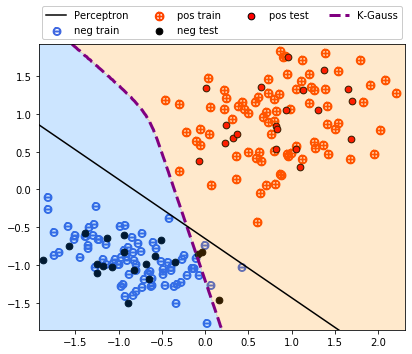

In [11]:
"""PERCEPTRON CON KERNEL"""
X_train=x_train[:]
X_test=x_test[:]

perceptronK = PerceptronKernel(kernel='gk',gamma=3)

perceptronK.fit(X_train, y_train)

"""TEST"""
y_p=perceptronK.predict(X_test)

ex,pr,rec = perceptronK.metricas(y_test,y_p)
print('MÉTRICAS PERCEPTRON CON KERNEL:')
print("Exactitud   " + str(ex) + "%")
print("Precision   " + str(pr) + "%")
print("Recall      " + str(rec) + "%")

"""FD's"""
fig,ax=grafica(x_train,y_train,x_test,y_test)

perceptron.plot_FD(ax)
plot_FD(perceptronK,show_SV=False)

## Prueba con datos más complejos

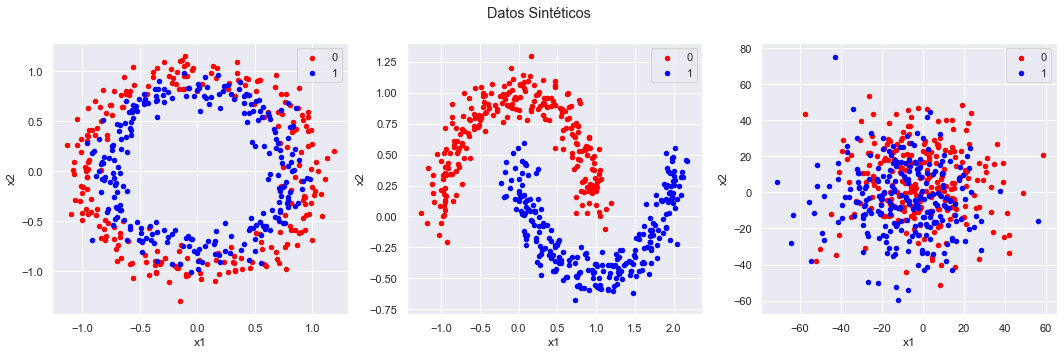

In [13]:
from sklearn.datasets import make_blobs, make_circles, make_moons
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

exp_size = 500

# generate 2d classification dataset
X_circ, y_circ = make_circles(n_samples=exp_size, noise=0.1,
                              random_state=1)
X_moon, y_moon = make_moons(n_samples=exp_size, noise=0.1,
                            random_state=1)

# generate 2d multi classification dataset
X_blob, y_blob = make_blobs(n_samples=exp_size, centers=2, cluster_std= 20,
                            n_features=2,random_state=1)

# scatter plot, dots colored by class value
df_circ = DataFrame(dict(x1 = X_circ[:,0], x2=X_circ[:,1], label=y_circ))
df_moon = DataFrame(dict(x1 = X_moon[:,0], x2=X_moon[:,1], label=y_moon))
colors_bin = {0:'red', 1:'blue'}

df_blob = DataFrame(dict(x1 = X_blob[:,0], x2=X_blob[:,1], label=y_blob))
colors_mult = {0:'red', 1:'blue', 2:'green', 3:'purple'}

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
fig.suptitle('Datos Sintéticos')

grouped = df_circ.groupby('label')
for key, group in grouped:
    group.plot(ax=ax1, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_moon.groupby('label')
for key, group in grouped:
    group.plot(ax=ax2, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_blob.groupby('label')
for key, group in grouped:
    group.plot(ax=ax3, kind='scatter', x='x1', y='x2', label=key, color=colors_mult[key])

&#9998; **Prueba el modelo del Perceptrón con kernel usando un Kernel Polinomial y Gaussiano. Prueba con varios parámetros.**

213 vectores de soporte de 350 puntos


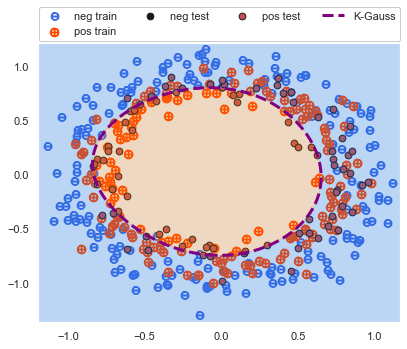

In [15]:
from sklearn.model_selection import train_test_split

Data=[(X_circ,y_circ),(X_moon,y_moon),(X_blob,y_blob)]
X,y=Data[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.StandardScaler()
# scaler = preprocessing.PowerTransformer()

""" TU CÓDIGO AQUI """

x_train=scaler.fit_transform(x_train)
x_test =scaler.fit_transform(x_test)

perceptronK = PerceptronKernel(kernel='gk',gamma=0.5,epocas=30)
perceptronK.fit(X_train, y_train)

""" -------------- """


"""FD's"""
fig,ax=grafica(X_train,y_train,X_test,y_test)

plot_FD(perceptronK,show_SV=False)


## TAREA:
* Prueba el modelo PerpcetronKernel con un kernel Gaussiano para distintos valores de Gamma.
* Guarda algunos resultados en un archivo (graficos) y comenta sobre el rol de Gamma en el modelo.